In [123]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import pepe
from pepe.simulate import genSyntheticResponse
from pepe.preprocess import circularMask

from IPython.display import clear_output
plt.rcParams["figure.dpi"] = 150

In [108]:
# Use pepe to generate fake photoelastic images
def genTrainingImages(batchsize, radius=150, minForce=0, maxForce=1, maxAlpha=.25, minBeta=0, maxBeta=np.pi, minNumForces=2, maxNumForces=4, fSigma=100, pxPerMeter=1e4, brightfield=False, noiseLevel=.05):
    numForces = np.random.randint(minNumForces, maxNumForces+1, size=batchsize)
    forceArr = [np.random.uniform(minForce, maxForce, size=numForces[i]) for i in range(batchsize)]
    # Normal for this one, since these are generally 0
    alphaArr = [np.random.normal(0, maxAlpha/2, size=numForces[i]) for i in range(batchsize)]
    betaArr = [np.random.uniform(minBeta, maxBeta, size=numForces[i]) for i in range(batchsize)]

    imageArr = np.zeros((batchsize, 2*radius, 2*radius))
    
    for i in range(batchsize):
        imageArr[i] = genSyntheticResponse(forceArr[i], alphaArr[i], betaArr[i], fSigma, radius, pxPerMeter, brightfield, imageSize=(2*radius, 2*radius))
    
    threeChannelImageArr = np.zeros((batchsize, 2*radius, 2*radius, 3), dtype=np.float64)
    
    for i in range(batchsize):
        threeChannelImageArr[i,:,:,0] = circularMask((2*radius, 2*radius), np.array((radius, radius), dtype=np.float64), radius)[:,:,0] * 0.5
        threeChannelImageArr[i,:,:,1] = imageArr[i] * 0.8
        
        threeChannelImageArr[i] += np.random.normal(0, noiseLevel, size=(2*radius, 2*radius, 3))
        threeChannelImageArr[i][threeChannelImageArr[i] > 1] = 1
        threeChannelImageArr[i][threeChannelImageArr[i] < 0] = 0
        
    return threeChannelImageArr

def convertToLuminance(images):
    newImages = np.zeros(images.shape[:3])
    yChannel = 0
    
    for i in range(len(images)):
        newImages[i] = tf.image.rgb_to_yuv(images[i])[:,:,yChannel]
        
    return newImages

ERROR! Session/line number was not unique in database. History logging moved to new session 5127


ERROR! Session/line number was not unique in database. History logging moved to new session 5129


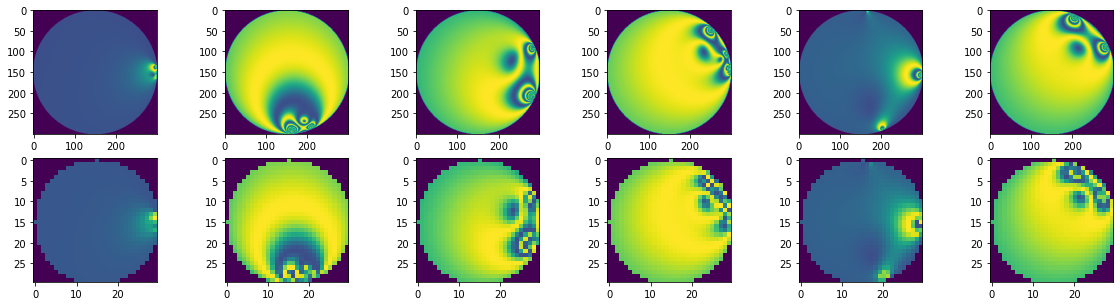

In [115]:
dsFactor = 10

fig, ax = plt.subplots(2, 6, figsize=(20, 5))

images = genTrainingImages(6, noiseLevel=0)
images = convertToLuminance(images)

for i in range(6):
    ax[0,i].imshow(images[i])
    ax[1,i].imshow(images[i][::dsFactor,::dsFactor])
    
plt.show()

In [116]:
# Set up the model
convArgs = {"activation": 'relu',
            "kernel_initializer": 'Orthogonal',
            "padding": 'same'}

inputs = keras.Input(shape=(None,None,1))
x = keras.layers.Conv2D(64, 5, **convArgs)(inputs)
x = keras.layers.Conv2D(64, 3, **convArgs)(x)
x = keras.layers.Conv2D(64, 3, **convArgs)(x)
x = keras.layers.Conv2D(dsFactor**2, 3, **convArgs)(x)
outputs = tf.nn.depth_to_space(x, dsFactor)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='MSE')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 100)   57700     
_________________________________________________________________
tf_op_layer_DepthToSpace_3 ( [(None, None, None, 1)]   0         
Total params: 133,220
Trainable params: 133,220
Non-trainable params: 0
_____________________________________________________

(1, 300, 300, 1)


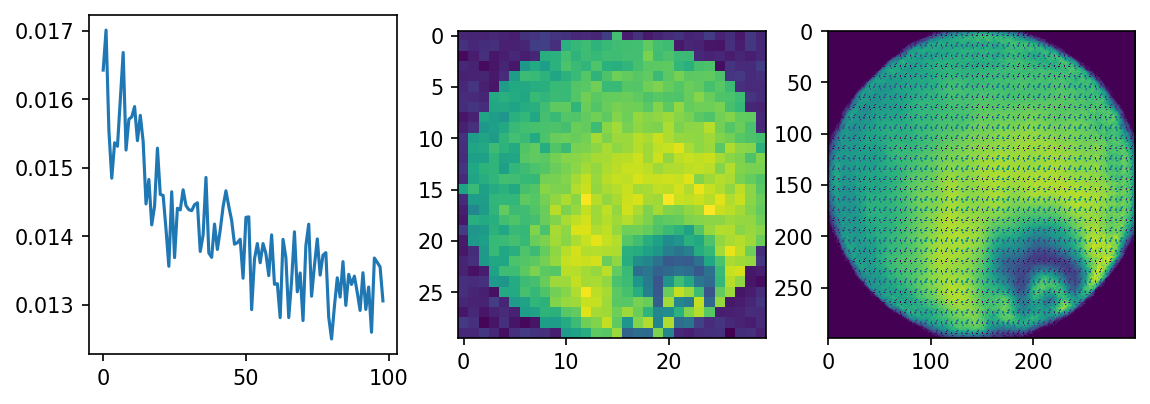

In [125]:
epochs = 100
batchsize = 100
noiseLevel = .03

lossArr = np.zeros(epochs)

for i in range(epochs):
    # Generate the images
    imageArr = genTrainingImages(batchsize+1, noiseLevel=0)
    imageArr = convertToLuminance(imageArr)
    
    # Downscale and add some noise
    dsImageArr = np.float64((imageArr + np.random.normal(0, noiseLevel, size=imageArr.shape))[:,::dsFactor,::dsFactor])
    
    lossArr[i] = model.train_on_batch(dsImageArr[:-1,:,:,None], imageArr[:-1,:,:,None])
    
    clear_output(wait=True)
    
    fig, ax = plt.subplots(1, 4, figsize=(11, 3))
    
    ax[0].plot(lossArr[:i])
    ax[0].set_yscale('log')
    ax[0].set_title('Loss')
    
    ax[1].imshow(dsImageArr[-1])
    ax[1].set_title('Network Input')
    
    ax[2].imshow(model(dsImageArr[-1:,:,:,None])[0])
    ax[2].set_title('Network Output')
    
    ax[3].imshow(imageArr[-1])
    ax[3].set_title('True Output')
    
    plt.show()

In [118]:
??model.train_on_batch

Signature:
model.train_on_batch(
    x,
    y=None,
    sample_weight=None,
    class_weight=None,
    reset_metrics=True,
)
Source:   
  def train_on_batch(self,
                     x,
                     y=None,
                     sample_weight=None,
                     class_weight=None,
                     reset_metrics=True):
    """Runs a single gradient update on a single batch of data.

    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
              (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
              (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
              if the model has named inputs.
          - A `tf.data` dataset.
        y: Target data. Like the input data `x`, it could be either Numpy
          array(s) or TensorFlow tensor(s). It should be consistent with `x`
          (you